# Graphs

In mathematics, a network is represented as a **graph**. A graph is a collection of **nodes** (also called *vertices*) and **edges** that connect pairs of nodes. A basic distinction in graph theory is between an **undirected graph**, in which the edge $(a,b)$ is identical to $(b,a)$, and a **directed graph** or **digraph**, in which $(a,b)$ and $(b,a)$ are different potential edges. In either type of graph, each edge might be labeled with a numerical value, which results in a **weighted graph**.

Undirected, unweighted graphs will give us plenty to handle, and we will not seek to go beyond them. We also will not consider graphs that allow a node to link to itself.

## NetworkX

The best-known Python package for working with networks is NetworkX.

In [1]:
import networkx as nx
import seaborn as sns
import pandas as pd

One way to create a graph is from a list of edges.

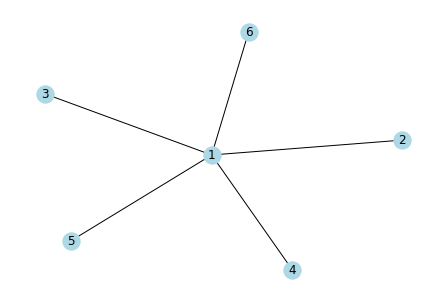

In [2]:
star = nx.Graph( [(1,2),(1,3),(1,4),(1,5),(1,6)] )
nx.draw(star,with_labels=True,node_color="lightblue")

Another way to create a graph is to give the start and end nodes of the edges as columns in a data frame.

   from  to
0     1   2
1     2   3
2     3   4
3     4   5
4     5   6
5     6   1


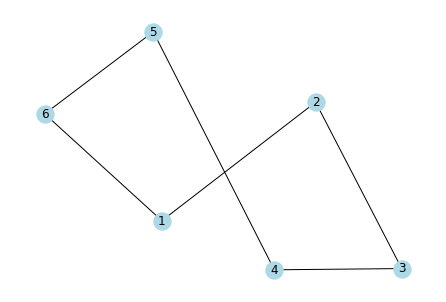

In [3]:
network = pd.DataFrame( {'from':[1,2,3,4,5,6],'to':[2,3,4,5,6,1]} )
print(network)
H = nx.from_pandas_edgelist(network,'from','to')
nx.draw(H,with_labels=True,node_color="lightblue")

We can conversely deconstruct a graph object into its nodes and edges. The results have special types that may need to be converted into sets, lists, or other objects.

In [4]:
print("Nodes as a list:")
print( list(star.nodes) )
print("\nNodes as an Index:")
print( pd.Index(star.nodes) )

Nodes as a list:
[1, 2, 3, 4, 5, 6]

Nodes as an Index:
Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')


It's also easy to find out which nodes are **adjacent** to a given node, i.e., connected to it by an edge. The result is that node's list of **neighbors**.

In [5]:
print("Neighbors of node 3 in graph H:",list(H[3]))

Neighbors of node 3 in graph H: [2, 4]


## Common graph types

There are functions that generate different well-studied types of graphs. The first graph constructed above is a **star graph**, and the graph `H` above is a **cycle graph**.

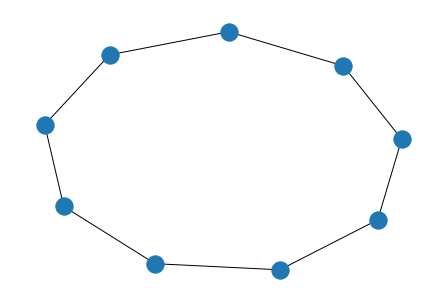

In [6]:
nx.draw(nx.cycle_graph(9))

A cross between the star and the cycle is a **wheel graph**.

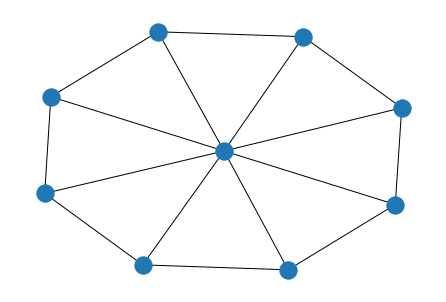

In [7]:
nx.draw(nx.wheel_graph(9))

A **complete graph** is one that has every possible edge.

5 nodes, 10 edges


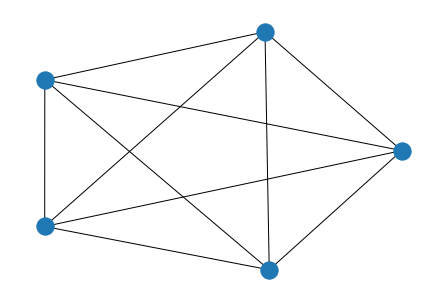

In [8]:
K5 = nx.complete_graph(5)
print("5 nodes,",nx.number_of_edges(K5),"edges")
nx.draw(K5)

In a graph on $n$ nodes, there are 

$$
\binom{n}{2} = \frac{n!}{(n-2)!2!} = \frac{n(n-1)}{2}
$$

unique pairs of distinct nodes. Hence, there are $\binom{n}{2}$ edges in the undirected complete graph on $n$ nodes.

A **lattice graph** has a regular structure, like graph paper.

20 nodes, 31 edges


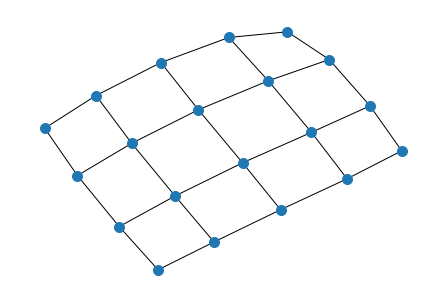

In [9]:
lat = nx.grid_graph((5,4))
print(lat.number_of_nodes(),"nodes,",lat.number_of_edges(),"edges")
nx.draw(lat,node_size=100)

In an $m\times n$ lattice graph, there are $m-1$ edges in one direction repeated $n$ times, plus $n-1$ edges in the other direction, repeated $m$ times. Thus there are 

$$
(m-1)n + (n-1)m = 2mn-(m+n)
$$

edges altogether.

There are different ways to draw a particular graph in the plane, as determined by the positions of the nodes. The default is to imagine that the edges are springs pulling on the nodes. But there are alternatives that may be useful at times.

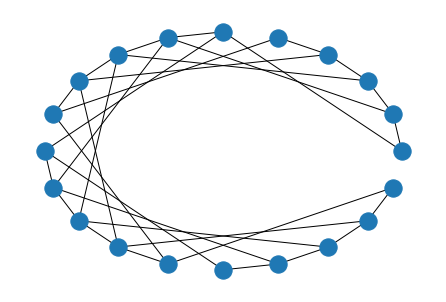

In [10]:
nx.draw_circular(lat)

As you can see, it's not easy to tell how similar two graphs are by comparing renderings of them.

## Adjacency matrix

Every graph can be associated with an **adjacency matrix**. Suppose the nodes are numbered from $0$ to $n-1$. The adjacency matrix is $n\times n$ and has a 1 at position $(i,j)$ if node $i$ and node $j$ are adjacent, and a 0 otherwise.

In [11]:
A = nx.adjacency_matrix(star)
A

<6x6 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

The matrix `A` is not stored in the format we have been used to. In a large network we would expect most of its entries to be zero, so it makes more sense to store it as a *sparse matrix*, where we keep track of only the nonzero entries.

In [12]:
print(A)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (2, 0)	1
  (3, 0)	1
  (4, 0)	1
  (5, 0)	1


We can easily convert `A` to a standard array, if it is not too large to fit in memory.

In [13]:
A.toarray()

array([[0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In an undirected graph, we have $A_{ij}=A_{ji}$ everywhere, and we say that $A$ is *symmetric*.

## Importing networks

There are many ways to read graphs from (and write them to) files. For example, here is a friend network among Twitch users.

In [14]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)

The file just imported has a pair of nodes representing one edge on each line. The nodes can have any names at all; by default they are interpreted as strings, which we overrode above to get integer node labels.

In [15]:
print("Twitch network has",twitch.number_of_nodes(),"nodes and",twitch.number_of_edges(),"edges")

Twitch network has 7126 nodes and 35324 edges


This graph is difficult to draw in its entirety. We can zoom in on a subset by selecting a node and its **ego graph**, which includes its neighbors along with all edges between the captured nodes.

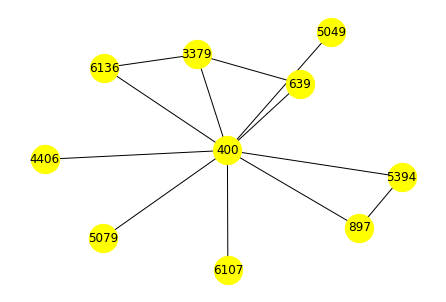

In [16]:
ego = nx.ego_graph(twitch,400)
nx.draw(ego,with_labels=True,node_size=800,node_color="yellow")

Notice that the nodes of the ego network have the same labels as they did in the graph that it was taken from. We can widen the ego graph to include the ego graphs of all the neighbors:

528 nodes and 1567 edges


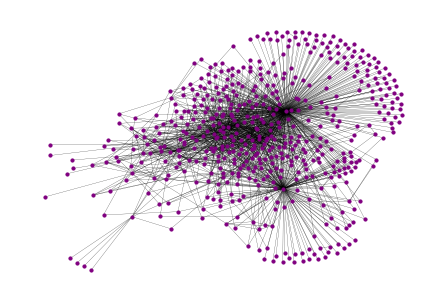

In [17]:
big_ego = nx.ego_graph(twitch,400,radius=2)
print(big_ego.number_of_nodes(),"nodes and",big_ego.number_of_edges(),"edges")

pos = nx.spring_layout(big_ego,iterations=60)
nx.draw(big_ego,pos=pos,width=0.2,node_size=10,node_color="purple")

The reason for the two-step process in making the drawing above is that computing the node positions via springs takes a hidden computational iteration. By calling that iteration explicitly, we were able to stop it early and save time.

## Degree and average degree

The **degree** of a node is the number of edges that have the node as an endpoint. Equivalently, it is the number of nodes in its ego graph, minus the original node itself. The **average degree** of a graph is the mean of the degrees of all of its nodes. 

The `degree` property of a graph gives a dictionary-style object of all nodes with their degrees.

In [18]:
ego.degree

DegreeView({897: 2, 400: 9, 5394: 2, 3379: 3, 4406: 1, 5079: 1, 6136: 2, 5049: 1, 6107: 1, 639: 2})

The result here can be a bit awkward to work with; it's actually a *generator* of a list, rather than the list itself. (This "lazy" attitude is useful when dealing with very large networks.) So, for instance, we can collect it into a list of ordered tuples:

In [19]:
list(ego.degree)

[(897, 2),
 (400, 9),
 (5394, 2),
 (3379, 3),
 (4406, 1),
 (5079, 1),
 (6136, 2),
 (5049, 1),
 (6107, 1),
 (639, 2)]

It can be convenient to use a series or frame to keep track of quantities like degree that are associated with nodes.

In [20]:
nodes = pd.Index(ego.nodes)
degrees = pd.Series(dict(ego.degree),index=nodes)
print("average degree of ego graph:",degrees.mean())

average degree of ego graph: 2.4


There's a much easier way to compute this particular quantity, however. If we sum the degrees of all the nodes in a graph, we must get twice the number of edges in the graph. For $n$ nodes and $e$ edges, the average degree is therefore $2m/n$.

In [21]:
def average_degree(g):
    return 2*g.number_of_edges()/g.number_of_nodes()

print("average degree of Twitch network:",average_degree(twitch))

average degree of Twitch network: 9.914117316867808


## Random graphs

One way of understanding a real-world network is by comparing it to ones that are constructed randomly, but according to relatively simple rules. The idea is that if the real network behaves similarly to members of some random family, then perhaps it is constructed according to similar principles.

An **Erdős-Rényi graph** (ER graph) includes each individual possible edge with a fixed probability $p$. That is, if you have a weighted coin that comes up heads (100p)% of the time, then you toss the coin for each possible pair of vertices and include their edge if it is heads.

50 nodes, 91 edges


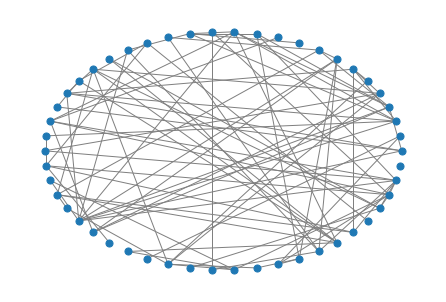

In [22]:
n,p = 50,0.08
ER = nx.erdos_renyi_graph(n,p,seed=2)
print(ER.number_of_nodes(),"nodes,",ER.number_of_edges(),"edges")
nx.draw_circular(ER,node_size=50,edge_color="gray")

Since there are $\binom{n}{2}$ unique pairs among $n$ nodes, the mean number of edges in an ER graph is 

$$
p\binom{n}{2} = \frac{pn(n-1)}{2}.
$$

This fact is usually stated in terms of the average node degree, $\bar{k}$:

$$
E[\bar{k}] = \frac{1}{n} pn(n-1) = p(n-1).
$$

There are two senses of "average" going on here: in each graph instance, you find the average degree, then you take the average (expectation, $E[\cdot]$) over all random instances. Here is the distribution of $\bar{k}$ over 10000 instances when its expected value is $4.0$:

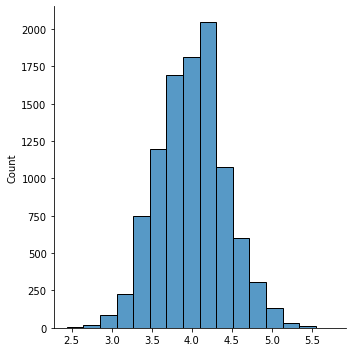

In [23]:
n,p = 41,0.1
kbar = []
for iter in range(10000):
    ER = nx.erdos_renyi_graph(n,p,seed=iter+1001)
    kbar.append(average_degree(ER))

sns.displot(x=kbar,bins=16);

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_0jts2mos&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_sra0i78m" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>

<!-- 
## Connectedness

+++

We say that two nodes in a network are **connected** if there is a path of edges between them. If every pair of nodes in the network are connected, then we say the *graph* is connected.

```{code-cell} ipython3
nx.is_connected(twitch)
```

If a subset $C$ of nodes (with associated edges) forms a connected graph, and there are no links from nodes in $C$ to nodes outside of $C$, then $C$ is a **connected component**. A connected graph has one connected component; the other extreme is a graph with no edges, in which the number of connected components equals the number of nodes.

```{code-cell} ipython3
ego.remove_edge(400,5079)
nx.draw_circular(ego,with_labels=True,node_size=800,node_color="yellow")
```

```{code-cell} ipython3
:tags: []

nx.number_connected_components(ego)
```

An **articulation node** is a node that, when removed (with its incident edges) from a graph, increases the number of connected components. Each articulation node is a "choke point" or hub for communication between otherwise disconnected subgraphs. The Twitch network has many such nodes.

```{code-cell} ipython3
ap = list(nx.articulation_points(twitch))
len(ap)
```

Removing an articulation node results in at least two connected components, but there might be more.

```{code-cell} ipython3
t2 = twitch.copy()
t2.remove_node(ap[0])
nx.number_connected_components(t2)
```
 -->